In [1]:
import instaseis
import matplotlib.pyplot as plt
import obspy
import numpy as np
import pandas as pd
from obspy.imaging.beachball import beachball
from obspy.imaging.beachball import mt2plane
from obspy.core.event.source import MomentTensor
#import MTfit

In [2]:
from obspy.geodetics import gps2dist_azimuth, locations2degrees
from obspy.geodetics.base import kilometer2degrees
from geopy.distance import geodesic
from geopy.point import Point
import math

In [3]:
db = instaseis.open_db("/projects/wg-BayesianFWI/")

In [4]:
def gauss_sliprate(t, mean=5,variance=1.0):
    """Gaussian sliprate function."""
    #dt=db.info.dt
    #npts=1000
    #times=np.linspace(-50, dt*npts, npts)
    sliprate = np.exp(-0.5*((t-mean)/variance)**2)
    sliprate /= np.sum(sliprate)
    return sliprate

def boxcar_sliprate(t, width=15):
    """Boxcar sliprate function."""
    slipratebox = np.ones_like(t)
    slipratebox[t > width] = 0
    return sliprate
    
def triangle_sliprate(t,start=5, midpoint = 15, apex = 25):
    """"triangle sliprate function 
        parameters
        t: array of time values incremented by dt
        start: time in secs at which rate starts
        midpoint: time in secs at which apex is reached
        apex: peak of triangle

        returns: array of normalized sliprates per dt
    """
   
    if start < 0 or midpoint < 0 or apex < 0:
        raise ValueError("All inputs (start, midpoint, apex) must be non-negative")
    if midpoint <= start:
        raise ValueError("The midpoint must be greater than start")
        
    slope1 = (apex-0) / (midpoint-start)
    yint1 = 0 - start*slope1
    y1 = slope1 * t + yint1
    xint = midpoint + (midpoint - start)
    slope2 = (apex - 0) / (midpoint - xint)
    yint2 = 0-slope2*xint

    y1[t >= midpoint] = slope2 * times[t >= midpoint] + yint2

    y1[y1 < 0] = 0
    sliprate = y1 / np.sum(y1)
   # sliprate = y1 / np.sum(y1)
    return sliprate

In [5]:
class Seismogram:
    def __init__(self):
        self._dist_in_degrees = 2
        self.data = None
        self.delta = None
        self.velocity_data = None
        self.accel_data = None
        self.source_lat = 0
        self.source_lon = 0 
        #self.receiver_lat = self.dist_in_degrees
        #self.receiver_lon = 0
        self.receiver_lat = 0
        self.receiver_lon = self.dist_in_degrees
        self.depth_in_m=10000
        
        # Default isotropic moment tensor components
        self.default_m_rr = 1e16
        self.default_m_tt = 1e16
        self.default_m_pp = 1e16
        self.default_m_rt = 0
        self.default_m_rp = 0
        self.default_m_tp = 0

        # Initialize with default moment tensor components
        self.m_rr = self.default_m_rr
        self.m_tt = self.default_m_tt
        self.m_pp = self.default_m_pp
        self.m_rt = self.default_m_rt
        self.m_rp = self.default_m_rp
        self.m_tp = self.default_m_tp
        
        self.sliprate = None
        self.dt = db.info.dt
        #self.starttime = obspy.UTCDateTime("1970-01-01T00:00:00.0")
        #self.endtime = self.starttime + 300
        
        # Initialize moment_tensor (if provided)
        self._moment_tensor = None
 
    @property
    def moment_tensor(self):
        return self._moment_tensor

    @moment_tensor.setter
    def moment_tensor(self, tensor):
        if tensor is None:
            self._moment_tensor = None
            self.m_rr = self.default_m_rr
            self.m_tt = self.default_m_tt
            self.m_pp = self.default_m_pp
            self.m_rt = self.default_m_rt
            self.m_rp = self.default_m_rp
            self.m_tp = self.default_m_tp
            return
            return
            
        # Validate that the tensor is a 3x3 numpy array
        if not isinstance(tensor, np.ndarray) or tensor.shape != (3, 3):
            raise ValueError("Moment tensor must be a 3x3 numpy array.")
       
        # Update the internal attribute
        self._moment_tensor = tensor

        # Update the individual components
        self.m_rr = tensor[0, 0]
        self.m_tt = tensor[1, 1]
        self.m_pp = tensor[2, 2]
        self.m_rt = tensor[0, 1]
        self.m_rp = tensor[0, 2]
        self.m_tp = tensor[1, 2]

    @property
    def dist_in_degrees(self):
        return self._dist_in_degrees

    @dist_in_degrees.setter
    def dist_in_degrees(self, value):
        self._dist_in_degrees = value
        self.receiver_lon = value  # Automatically update source_lon when dist_in_degrees is set

        
    def custom_seismogram(self,**kwargs):
        """
        Generate a seismogram using Instaseis with Gaussian, boxcar, or triangle or optional 
        custom sliprate function.
    
        Parameters:
            source_lat: source event longitude
            source_lon: source event latitude
            receiver_lat: receiver event longitude
            receiver_lon: receiver event latitude
            depth_in_m: depth to even origin in meters
            m_rr,m_tt, m_pp, m_rt, m_rp, m_tp: moments defining moment tensor around radial,
            theta, and phi directions; default is set to an isotropic source moment tensor
            database: Instaseis database object.
            source: Instaseis source object.
            receiver: Instaseis receiver object.
            sliprate: None (use database default), 'Gauss', 'boxcar', or a custom function.
            kwargs--mean: mean for Gaussian sliprate function, default is 5
            kwargs--variance: variance for Gaussian sliprate function, default is 1
            kwargs--width: width for boxcar sliprate function, default is 15
            db: seismic database
            **kwargs: Additional parameters for the sliprate functions, e.g., mean, variance or width.
        """
        sliprate_options = {
        "Gauss": gauss_sliprate,
        "boxcar": boxcar_sliprate,
        "triangle": triangle_sliprate
        }
        #print(self.sliprate)
        # Determine sliprate function
        # if sliprate is None, use default stf from db and return seismogram
        if self.sliprate is None:
            print('No sliprate was specified; using default STF from db')
            sliprate_function = None  # Use database default
            source = instaseis.Source(
                latitude = self.source_lat,
                longitude = self.source_lon,
                depth_in_m= self.depth_in_m,
                m_rr = self.m_rr,
                m_tt = self.m_tt,
                m_pp = self.m_pp,
                m_rt = self.m_rt,
                m_rp = self.m_rp,
                m_tp = self.m_tp,
                sliprate=sliprate_function)
                #dt=self.dt)
            receiver = instaseis.Receiver(
                latitude=self.receiver_lat,
                longitude=self.receiver_lon)
            seismogram=db.get_seismograms(source=source, receiver=receiver)
            self.data = {
            'Z': seismogram.select(component="Z")[0].data,
            'N': seismogram.select(component="N")[0].data,
            'E': seismogram.select(component="E")[0].data
            }
           
            self.delta = seismogram.select(component="Z")[0].stats.delta
            return
            #return self
        # if gauss or boxcar, if neither, throws an error
        elif isinstance(self.sliprate, str):
            if self.sliprate in sliprate_options:
                sliprate_function = lambda t: sliprate_options[self.sliprate](t, **kwargs)
                #print(f'using {self.sliprate} sliprate function')
            else:
                raise ValueError(f"Sliprate option '{self.sliprate}' is not recognized. Available options are: {list(sliprate_options.keys())}.")
        # custom sliprate function
        elif callable(self.sliprate):
            sliprate_function = self.sliprate
            print('using custom STF')
        else:
            raise TypeError("Sliprate must be None, a recognized string, or a callable function.")
    
        # get values of sliprate function by evaluating at discrete time points
        dt=db.info.dt
        npts=1000
        times=np.linspace(-50, dt*npts, npts)  # Example time array; adjust as needed
        sliprate_values = sliprate_function(times)
    
        # Generate and return the seismogram
        source = instaseis.Source(
            latitude = self.source_lat,
            longitude = self.source_lon,
            depth_in_m=self.depth_in_m,
            m_rr = self.m_rr,
            m_tt = self.m_tt,
            m_pp = self.m_pp,
            m_rt = self.m_rt,
            m_rp = self.m_rp,
            m_tp = self.m_tp,
            sliprate=sliprate_values,
            dt=self.dt)
        
        source.set_sliprate(sliprate_values, dt, time_shift=0, normalize=True)
        receiver = instaseis.Receiver(
                latitude=self.receiver_lat,
                longitude=self.receiver_lon)
        seismogram=db.get_seismograms(source=source, receiver=receiver, reconvolve_stf=True, remove_source_shift=False)
        self.data = {
            'Z': seismogram.select(component="Z")[0].data,
            'N': seismogram.select(component="N")[0].data,
            'E': seismogram.select(component="E")[0].data
        }
        self.delta = seismogram.select(component="Z")[0].stats.delta
        #print(self.delta)
        

    def get_response(self, resp = 'VEL'):
        """
        calculate velocity 'VEL' or acceleration 'ACCEL'
        updates velocity_data or accel_data of Seismogram instance
        """
        if self.data is None:
            raise ValueError("Displacement has not been generated yet")
        elif resp == "VEL":
            self.velocity_data = {comp: np.gradient(data, self.delta) for comp, data in self.data.items()}
        elif resp == "ACCEL":
            self.accel_data = {comp: np.gradient(np.gradient(data, self.delta), self.delta) for comp, data in self.data.items()}
        else: 
            raise ValueError("resp value not recognized. Choices are either 'VEL' or 'ACCEL' ")

    def compute_integrated_signal_power(self):
        """Calculate the integrated signal power of the velocity."""
        if self.velocity_data is None:
            raise ValueError("Velocity data has not been generated yet. Call 'get_response(resp=\"VEL\")' first.")
       
        power = 0
        for comp, values in self.velocity_data.items():
            power += np.sum(values**2) * self.delta  # Sum of squared values times the sampling interval
       
        return power

    def compute_maximum_magnitude(self, data_type="DISP"):
        """
        Calculate the maximum magnitude (displacement, velocity, or acceleration).
       
        Parameters:
        - data_type (str): The type of data to compute the magnitude for. Options are "DISP", "VEL", "ACCEL".
       
        Returns:
        - max_magnitude (float): The maximum magnitude observed.
        """
        if data_type == "DISP":
            data = self.data
        elif data_type == "VEL":
            if self.velocity_data is None:
                raise ValueError("Velocity data has not been generated yet. Call 'get_response(resp=\"VEL\")' first.")
            data = self.velocity_data
        elif data_type == "ACCEL":
            if self.accel_data is None:
                raise ValueError("Acceleration data has not been generated yet. Call 'get_response(resp=\"ACCEL\")' first.")
            data = self.accel_data
        else:
            raise ValueError("Invalid data_type. Options are 'DISP', 'VEL', or 'ACCEL'.")
       
        # Compute magnitude at each time step
        magnitudes = np.sqrt(
            data["Z"]**2 + data["N"]**2 + data["E"]**2
        )
       
        # Return the maximum magnitude
        return np.max(magnitudes)


    def compute_total_power(self):
        """Calculate the total power for velocity across all three components."""
        if self.velocity_data is None:
            raise ValueError("Velocity data has not been generated yet. Call 'get_response(resp=\"VEL\")' first.")
       
        total_power = 0
        for comp, values in self.velocity_data.items():
            total_power += np.sum(values**2) * self.delta # Sum of squared values times the sampling interval
       
        return total_power

    def plot(self, data_type="DISP", starttime=None, endtime=None):
        """
        Plot the seismogram data (displacement, velocity, or acceleration) for Z, N, and E components.
       
        Parameters:
        - data_type (str): The type of data to plot. Options are "DISP", "VEL", "ACCEL".
                           "DISP" plots displacement (default),
                           "VEL" plots velocity,
                           "ACCEL" plots acceleration.
        - starttime (float): Start time in seconds for the x-axis (default is the beginning of the data).
        - endtime (float): End time in seconds for the x-axis (default is the end of the data).
        """
        # Determine the data to plot
        if data_type == "DISP":
            data = self.data
            title = "Displacement"
        elif data_type == "VEL":
            if self.velocity_data is None:
                raise ValueError("Velocity data has not been generated yet. Call 'get_response(resp=\"VEL\")' first.")
            data = self.velocity_data
            title = "Velocity"
        elif data_type == "ACCEL":
            if self.accel_data is None:
                raise ValueError("Acceleration data has not been generated yet. Call 'get_response(resp=\"ACCEL\")' first.")
            data = self.accel_data
            title = "Acceleration"
        else:
            raise ValueError("Invalid data_type. Options are 'DISP', 'VEL', or 'ACCEL'.")
    
        # Create time axis based on delta
        npts = len(next(iter(data.values())))  # Get number of samples from any component
        times = np.arange(0, npts * self.delta, self.delta)
    
        # Apply starttime and endtime
        if starttime is None:
            starttime = times[0]
        if endtime is None:
            endtime = times[-1]
    
        # Select the time range for plotting
        mask = (times >= starttime) & (times <= endtime)
        times_zoomed = times[mask]
    
        # Plot each component
        fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
        for ax, (comp, values) in zip(axes, data.items()):
            ax.plot(times_zoomed, values[mask], label=f"{comp}-Component")
            ax.set_ylabel(f"{title} ({comp})")
            ax.legend(loc="upper right")
            ax.grid(True)
       
        axes[-1].set_xlabel("Time (s)")
        fig.suptitle(f"{title} Seismogram")
        plt.tight_layout()
        plt.show()


In [6]:
# from Modern Global Seismology. Thorne Lay & Terry C. Wallace. Pg 343.
# NOTE: slip=rake
# Example usage
#strike = 45  # degrees
#dip = 30     # degrees
#slip = 90    # degrees
def make_EQ_tensor_EMB(strike, dip, slip):
    # Calculate the tensor terms for an arbitrarily oriented double couple EQ given
    # strike, dip, and slip angles (in degrees)

    # Convert to radians
    delta = np.radians(dip)
    phi = np.radians(strike)
    lambda_ = np.radians(slip)

    # Initialize the tensor matrix
    M = np.zeros((3, 3))

    M[0, 0] = -1 * (np.sin(delta) * np.cos(lambda_) * np.sin(2 * phi) +
                   np.sin(2 * delta) * np.sin(lambda_) * (np.sin(phi) ** 2))
    M[1, 1] = (np.sin(delta) * np.cos(lambda_) * np.sin(2 * phi) -
               np.sin(2 * delta) * np.sin(lambda_) * (np.cos(phi) ** 2))
    M[2, 2] = -(M[0, 0] + M[1, 1])
    M[0, 1] = (np.sin(delta) * np.cos(lambda_) * np.cos(2 * phi) +
               0.5 * np.sin(2 * delta) * np.sin(lambda_) * np.sin(2 * phi))
    M[0, 2] = -(np.cos(delta) * np.cos(lambda_) * np.cos(phi) +
                np.cos(2 * delta) * np.sin(lambda_) * np.sin(phi))
    M[1, 2] = -(np.cos(delta) * np.cos(lambda_) * np.sin(phi) -
                np.cos(2 * delta) * np.sin(lambda_) * np.cos(phi))
    
    # Symmetric entries
    M[1, 0] = M[0, 1]
    M[2, 0] = M[0, 2]
    M[2, 1] = M[1, 2]

    return M
#dc_component = make_EQ_tensor_EMB(strike, dip, slip)
#print(dc_component)

In [7]:
def generate_moment_tensor(strike=None, dip=None, slip=None):
    """
    Generate a synthetic moment tensor based on ISO, CLVD, and DC components.

    Parameters:
    - strike (float, optional): Strike angle in degrees (default: sampled from [0, 360]).
    - dip (float, optional): Dip angle in degrees (default: sampled from [0, 90]).
    - slip (float, optional): Slip (rake) angle in degrees (default: sampled from [-180, 180]).

    Returns:
    - moment_tensor_scaled (np.ndarray): A 3x3 scaled moment tensor.
    """

    # Step 1: Sample ISO, CLVD, DC weights
    weights = np.random.dirichlet([1, 1, 8])  # Adjust alpha parameters for different distributions
    w_iso, w_clvd, w_dc = weights

    # Step 2: Define base components
    iso_component = np.array([[1, 0, 0],
                              [0, 1, 0],
                              [0, 0, 1]]) / 3

    clvd_component = np.array([[2, 0, 0],
                                [0, -1, 0],
                                [0, 0, -1]])

    # Step 3: Determine strike, dip, and slip
    if strike is None:
        strike = np.random.uniform(0, 360)  # Sample strike if not provided
    if dip is None:
        dip = np.random.uniform(0, 90)  # Sample dip if not provided
    if slip is None:
        slip = np.random.uniform(-180, 180)  # Sample slip if not provided

    # Step 4: Generate DC component based on strike, dip, and slip
    dc_component = make_EQ_tensor_EMB(strike, dip, slip)  # Ensure this function is defined elsewhere

    # Step 5: Combine components
    moment_tensor = (
        w_iso * iso_component +
        w_clvd * clvd_component +
        w_dc * dc_component
    )

    # Step 6: Sample moment magnitude (Mw) and compute seismic moment (M0)
    # Mw = np.random.uniform(3.5, 8.5)  # Adjust range as needed
    #Mw = 5
    #M0 = 10 ** (1.5 * Mw + 9.1)
    # M0 = 1

    # Step 7: Scale the moment tensor
    #moment_norm = np.sqrt(0.5 * np.sum(moment_tensor**2))  # Frobenius norm
    #moment_tensor_scaled = moment_tensor * (M0 / moment_norm)

    #return moment_tensor_scaled
    return moment_tensor

In [10]:
from obspy.imaging.beachball import beachball
from obspy.imaging.beachball import mt2plane

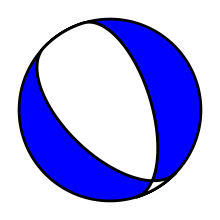

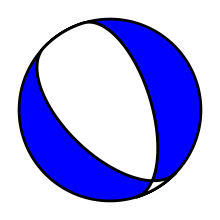

In [9]:
beachball(mt)

In [11]:
# Wrap it in an object with .mt attribute (mimicking ObsPy's internal structure)
class DummyMT:
    def __init__(self, mt):
        self.mt = mt

wrapped_mt = DummyMT(moment_tensor)

# Use mt2plane to get the nodal plane (strike, dip, rake)
np_obj = mt2plane(wrapped_mt)
strike = np_obj.strike
dip = np_obj.dip
rake = np_obj.rake

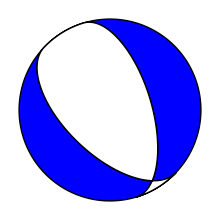

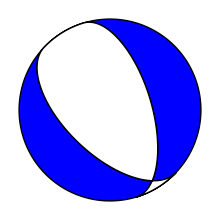

In [12]:
beachball([strike, dip, rake], size=100, linewidth=1, facecolor='b')

In [28]:
#from obspy.imaging.beachball import aux_plane
# Your 3x3 moment tensor as a NumPy array
mt_matrix = np.array([
    [0, 1, 0],
    [1, 0, 0],
    [0, 0, 0]
])

# Wrap it in an ObsPy MomentTensor object
mt = MomentTensor()
mt.mt = moment_tensor

# Now use mt2plane
nodal_plane = mt2plane(mt)

print(nodal_plane)  # Has .strike, .dip, .rake attributes

In [30]:
print(nodal_plane.rake)
print(nodal_plane.strike)
print(nodal_plane.dip)

226.36229338483378
176.80436297641384
81.79546061383286


In [16]:
seistest.depth_in_m = 1000
#seistest.sliprate = "Gauss"

In [17]:
seistest.custom_seismogram(mean=5, variance=2)

In [8]:
#seistest.plot(endtime=400)

In [28]:
nums=np.linspace(.0,3,20)

In [29]:
powers_list = []   

Moment_tensor = generate_moment_tensor()
for i in nums:
    seis_obj = Seismogram()
    seis_obj.depth_in_m = 10000
    seis_obj.dist_in_degrees = i
    seis_obj.sliprate = "Gauss"
    seis_obj.moment_tensor = Moment_tensor
    # calculate seismogram
    var=np.random.uniform(1, 3, 1)[0]
    seis_obj.custom_seismogram(variance=2)
    #seis_obj.custom_seismogram()
    seis_obj.get_response(resp = 'VEL')
    #print(seis_obj.dist_in_degrees)
    mag = seis_obj.compute_maximum_magnitude(data_type="VEL")
    powers_list.append(mag)

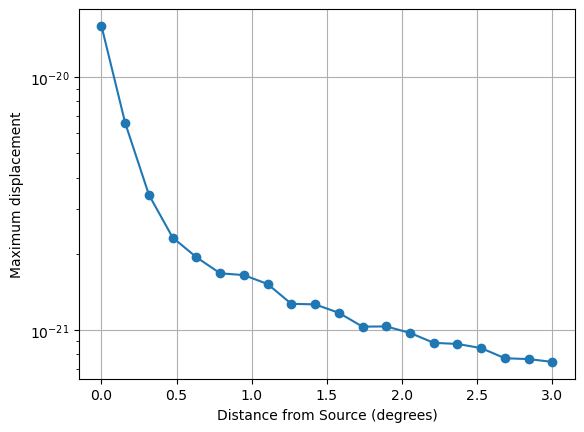

In [30]:
plt.yscale('log')
plt.plot(nums, powers_list, marker='o')
plt.xlabel("Distance from Source (degrees)")
plt.ylabel("Maximum displacement")
plt.grid(True)
plt.show()

0
No sliprate was specified; using default STF from db
1
No sliprate was specified; using default STF from db
2
No sliprate was specified; using default STF from db
3
No sliprate was specified; using default STF from db
4
No sliprate was specified; using default STF from db
5
No sliprate was specified; using default STF from db
6
No sliprate was specified; using default STF from db
7
No sliprate was specified; using default STF from db
8
No sliprate was specified; using default STF from db
9
No sliprate was specified; using default STF from db
10
No sliprate was specified; using default STF from db
11
No sliprate was specified; using default STF from db
12
No sliprate was specified; using default STF from db
13
No sliprate was specified; using default STF from db
14
No sliprate was specified; using default STF from db
15
No sliprate was specified; using default STF from db
16
No sliprate was specified; using default STF from db
17
No sliprate was specified; using default STF from db
18

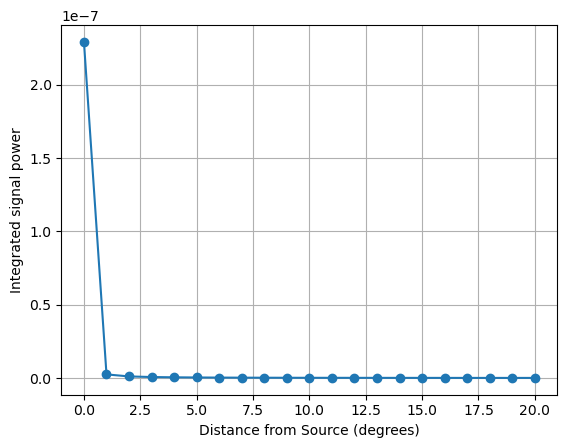

In [43]:
powers_list = []   
seis_obj = Seismogram()
for i in range(1,21):
    seis_obj.dist_in_degrees = i
    print(seis_obj.dist_in_degrees)
    seis_obj.custom_seismogram()
    seis_obj.get_response(resp="VEL")
    power = seis_obj.compute_integrated_signal_power()
    powers_list.append(power)

plt.yscale('log')
plt.plot([i for i in range(0,21)], powers_list, marker='o')
plt.xlabel("Distance from Source (degrees)")
plt.ylabel("Integrated signal power")
plt.grid(True)
plt.show()

This generates the seismic data. We sample depth, distance in degrees to source, and the variance for the Gaussian sliprate function from uniform distributions. Then, the moment tensor is generated (see code above). Within the moment tensor generating code, the slip/dip/strike are sampled from uniform distributions; however, I did not include these as inputs b/c previous analyses showed they were not important for GP model fitting. The maximum magnitude and integrated power are calculated as QOIs, and the final dataset is saved.

In [21]:
num_iters = 2000
data = []
for i in range(1, num_iters):
    # sample depth (m)
    Depth = np.random.uniform(1000, 40000, 1)[0]
    # sample distance in degrees between events
    Distance_in_degrees  = np.random.uniform(0, 3, 1)[0]
    # sample variance of Gaussian sliprate function
    Gaussian_variance = np.random.uniform(1, 3, 1)[0]
    #Gaussian_variance = 1.5
    # sample moment tensor
    # strike/dip/slip values and magnitude are sampled from uniform dists in this function
    #strike = strike = np.random.uniform(0, 360)
    
    #dip = np.random.uniform(0, 90) 
    
    #slip = np.random.uniform(-180, 180) 
    
    #moment_tensor = make_EQ_tensor_EMB(strike, dip, slip)
    #print(moment_tensor)
    Moment_tensor = generate_moment_tensor()

    # Initiate Seismogram object
    Seis_obj = Seismogram()
    Seis_obj.depth_in_m = Depth
    Seis_obj.distance_in_degrees = Distance_in_degrees
    Seis_obj.moment_tensor = Moment_tensor

    # get components of moment tensor
    m_rr = Seis_obj.m_rr
    m_tt = Seis_obj.m_tt
    m_pp = Seis_obj.m_pp
    m_rt = Seis_obj.m_rt
    m_rp = Seis_obj.m_rp
    m_tp = Seis_obj.m_tp
    # use Gaussian sliprate
    Seis_obj.sliprate = "Gauss"

    # calculate seismogram
    Seis_obj.custom_seismogram(mean=5, variance=Gaussian_variance)

    # compute velocity 
    Seis_obj.get_response(resp="VEL")
    # compute integrated power and max magnitude
    Integrated_power = Seis_obj.compute_integrated_signal_power()
    Max_magnitude = Seis_obj.compute_maximum_magnitude(data_type="VEL")
    
    data.append({"Depth": Depth, "Distance_in_degrees": Distance_in_degrees, "Gaussian_variance": Gaussian_variance,
                 "Integrated_power":Integrated_power, "Max_Mag":Max_magnitude, "m_rr": m_rr, "m_tt": m_tt, "m_pp":m_pp, "m_rt":m_rt, 
                 "m_rp":m_rp, "m_tp":m_tp})
    
data = pd.DataFrame(data)

In [9]:
data

,Depth,Distance_in_degrees,Gaussian_variance,Integrated_power,Max_Mag,m_rr,m_tt,m_pp,m_rt,m_rp,m_tp
0,25012.563016,0.000000,1.5,5.748217e-43,1.789458e-22,0.717320,-0.122083,-0.480311,0.140667,-0.514666,-0.235474
1,25012.563016,0.157895,1.5,5.748217e-43,1.789458e-22,0.717320,-0.122083,-0.480311,0.140667,-0.514666,-0.235474
2,25012.563016,0.315789,1.5,5.748217e-43,1.789458e-22,0.717320,-0.122083,-0.480311,0.140667,-0.514666,-0.235474
3,25012.563016,0.473684,1.5,5.748217e-43,1.789458e-22,0.717320,-0.122083,-0.480311,0.140667,-0.514666,-0.235474
4,25012.563016,0.631579,1.5,5.748217e-43,1.789458e-22,0.717320,-0.122083,-0.480311,0.140667,-0.514666,-0.235474
...,...,...,...,...,...,...,...,...,...,...,...
195,9870.357125,2.368421,1.5,4.675116e-42,7.771199e-22,-0.260955,-0.229544,0.721194,-0.332566,-0.234699,-0.171708
196,9870.357125,2.526316,1.5,4.675116e-42,7.771199e-22,-0.260955,-0.229544,0.721194,-0.332566,-0.234699,-0.171708
197,9870.357125,2.684211,1.5,4.675116e-42,7.771199e-22,-0.260955,-0.229544,0.721194,-0.332566,-0.234699,-0.171708
198,9870.357125,2.842105,1.5,4.675116e-42,7.771199e-22,-0.260955,-0.229544,0.721194,-0.332566,-0.234699,-0.171708


In [35]:
data.to_csv("seismogram_data7.csv", index=False) 

In [15]:
dfGP = pd.read_csv('seismogram_data7.csv')
dfGP.head()

,Depth,Distance_in_degrees,Gaussian_variance,Max_Mag,m_rr,m_tt,m_pp,m_rt,m_rp,m_tp
0,14706.736002,0.000000,2.289158,1.624298e-21,0.183442,0.69424,-0.808709,-0.004149,0.133423,-0.353457
1,14706.736002,0.333333,2.289158,8.829116e-22,0.183442,0.69424,-0.808709,-0.004149,0.133423,-0.353457
2,14706.736002,0.666667,2.289158,3.731970e-22,0.183442,0.69424,-0.808709,-0.004149,0.133423,-0.353457
3,14706.736002,1.000000,2.289158,3.163852e-22,0.183442,0.69424,-0.808709,-0.004149,0.133423,-0.353457
4,14706.736002,1.333333,2.289158,2.439946e-22,0.183442,0.69424,-0.808709,-0.004149,0.133423,-0.353457


In [8]:
# Number of moment tensors to sample
num_moment_tensors = 600
# Number of distance values to sample for each moment tensor
num_distance_values = 10

# Generate moment tensors
moment_tensors = [generate_moment_tensor() for _ in range(num_moment_tensors)]

# Prepare a list to store the data
data = []

# Loop through each moment tensor
for moment_tensor in moment_tensors:
    # Sample depth (m)
    Depth = np.random.uniform(1000, 40000, 1)[0]
    
    # Keep the Gaussian variance constant (you can set it to any value between 1 and 3)
    Gaussian_variance = np.random.uniform(1, 3, 1)[0]  # Example constant value for Gaussian variance
    
    # Generate 20 increasing values of Distance_in_degrees between 0 and 3
    distances = np.linspace(0, 3, num_distance_values)

    for Distance_in_degrees in distances:
        seis_obj = Seismogram()
        seis_obj.depth_in_m = Depth
        seis_obj.dist_in_degrees = Distance_in_degrees
        seis_obj.sliprate = "Gauss"
        seis_obj.moment_tensor = moment_tensor
        # calculate seismogram
        seis_obj.custom_seismogram(variance=Gaussian_variance)
        seis_obj.get_response(resp = 'VEL')
        #print(seis_obj.dist_in_degrees)
        mag = seis_obj.compute_maximum_magnitude(data_type="VEL")
       
        # Get components of moment tensor
        m_rr = seis_obj.m_rr
        m_tt = seis_obj.m_tt
        m_pp = seis_obj.m_pp
        m_rt = seis_obj.m_rt
        m_rp = seis_obj.m_rp
        m_tp = seis_obj.m_tp

        data.append({
            "Depth": Depth,
            "Distance_in_degrees": Distance_in_degrees,
            "Gaussian_variance": Gaussian_variance,
           # "Integrated_power": Integrated_power,
            "Max_Mag": mag,
            "m_rr": m_rr,
            "m_tt": m_tt,
            "m_pp": m_pp,
            "m_rt": m_rt,
            "m_rp": m_rp,
            "m_tp": m_tp
        })
      
data = pd.DataFrame(data)

In [9]:
data.head()

,Depth,Distance_in_degrees,Gaussian_variance,Max_Mag,m_rr,m_tt,m_pp,m_rt,m_rp,m_tp
0,24987.957793,0.000000,2.477212,5.752747e-22,0.263888,-0.792512,0.58607,0.315011,-0.374022,-0.354821
1,24987.957793,0.333333,2.477212,3.453112e-22,0.263888,-0.792512,0.58607,0.315011,-0.374022,-0.354821
2,24987.957793,0.666667,2.477212,2.258283e-22,0.263888,-0.792512,0.58607,0.315011,-0.374022,-0.354821
3,24987.957793,1.000000,2.477212,1.408450e-22,0.263888,-0.792512,0.58607,0.315011,-0.374022,-0.354821
4,24987.957793,1.333333,2.477212,1.107943e-22,0.263888,-0.792512,0.58607,0.315011,-0.374022,-0.354821


0.42198290970156993

Step 1: make a dataframe containing randomly sampled depths, azimuths and distances.
Step 2: calculate lat/lons for receiver location, assuming lat,lon=0,0 for the source; append the lat/lons to the dataframes from Step 1
Step 3: For each row in the dataframe, sample a moment tensor from original seismic data. Then, rotate that moment tensor according to the azimuth from the new dataframe. Append the rotated moment tensor components to the new dataframe.
Step 4: Make predictions onto the new data using the fitted GP.

In [10]:
# Step 1: Generate random samples (this is without Gaussian variance for sliprate function)
# for each of the 20 azimuths and 10 distances around a sources, we use the same depth and Gaussian variance
# for the sliprate function

np.random.seed(42)  # For reproducibility
num_reps=30
# Randomly sample depths
depths = np.random.uniform(1000, 40000, num_reps)

# Define azimuths
azimuths = np.linspace(0, 360, 20, endpoint=False)

# Randomly sample distances in degrees to source
distances = np.linspace(0,3,10)

variances = np.random.uniform(1, 3, num_reps)

# Step 2: Create combinations
# Create a DataFrame with all combinations
depths_repeated = np.repeat(depths, len(azimuths) * len(distances))
azimuths_repeated = np.tile(np.repeat(azimuths, len(distances)), len(depths))
distances_repeated = np.tile(distances, len(depths) * len(azimuths))
variances_repeated = np.repeat(variances, len(azimuths) * len(distances))

# Create a DataFrame
df = pd.DataFrame({
    'Depth (m)': depths_repeated,
    'Azimuth (degrees)': azimuths_repeated,
    'Distance (degrees)': distances_repeated,
    'Gaussian_variance': variances_repeated
})
df.head()

,Depth (m),Azimuth (degrees),Distance (degrees),Gaussian_variance
0,15607.064635,0.0,0.000000,2.21509
1,15607.064635,0.0,0.333333,2.21509
2,15607.064635,0.0,0.666667,2.21509
3,15607.064635,0.0,1.000000,2.21509
4,15607.064635,0.0,1.333333,2.21509


In [11]:
# Step 3: Calculate Receiver Coordinates
def calculate_receiver_location_geopy(lat, lon, azimuth, distance_degrees):
    # Create a point for the source location
    source_point = Point(lat, lon)
    
    # Convert distance from degrees to kilometers
    distance_kilometers = distance_degrees * 111.32  # Convert degrees to kilometers
    
    # Calculate the destination point using geodesic
    destination_point = geodesic(kilometers=distance_kilometers).destination(source_point, azimuth)
    
    return destination_point.latitude, destination_point.longitude

# Calculate coordinates for each row in the DataFrame
df['Receiver Latitude'], df['Receiver Longitude'] = zip(*df.apply(
    lambda row: calculate_receiver_location_geopy(0.0, 0.0, row['Azimuth (degrees)'], row['Distance (degrees)']),
    axis=1
))

# Display the resulting DataFrame
df.shape

(6000, 6)

In [12]:
def rotate_moment_tensor_components(m_rr, m_tt, m_pp, m_rt, m_rp, m_tp, azimuth_deg):
    """
    Rotate a moment tensor (given in its six unique components) around the Z-axis by a given azimuth.
    Returns the rotated moment tensor components in the same format.
    """
    # Construct full symmetric moment tensor matrix
    M = np.array([
        [m_rr, m_rt, m_rp],
        [m_rt, m_tt, m_tp],
        [m_rp, m_tp, m_pp]
    ])

    # Construct rotation matrix about Z-axis (radians)
    theta = np.radians(azimuth_deg)
    R = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta),  np.cos(theta), 0],
        [0, 0, 1]
    ])

    # Apply rotation
    M_rotated = R @ M @ R.T

    # Extract rotated components
    m_rr_rot = M_rotated[0, 0]
    m_tt_rot = M_rotated[1, 1]
    m_pp_rot = M_rotated[2, 2]
    m_rt_rot = M_rotated[0, 1]
    m_rp_rot = M_rotated[0, 2]
    m_tp_rot = M_rotated[1, 2]

    return pd.Series({
        "m_rr": m_rr_rot,
        "m_tt": m_tt_rot,
        "m_pp": m_pp_rot,
        "m_rt": m_rt_rot,
        "m_rp": m_rp_rot,
        "m_tp": m_tp_rot
    })

In [13]:
def append_rotated_moment_tensors(dfnew, dfGP):
    """
    For each row in dfnew, sample a moment tensor from dfGP,
    rotate it according to the azimuth in dfnew, and append
    the rotated components as new columns.
    """
    rotated_rows = []

    for _, row in dfnew.iterrows():
        # Step 1: Randomly sample a moment tensor from dfGP
        sampled = dfGP.sample(n=1).iloc[0]

        # Step 2: Rotate it using azimuth from the dfnew row
        rotated = rotate_moment_tensor_components(
            sampled["m_rr"], sampled["m_tt"], sampled["m_pp"],
            sampled["m_rt"], sampled["m_rp"], sampled["m_tp"],
            row["Azimuth (degrees)"]
        )

        rotated_rows.append(rotated)

    # Step 3: Combine rotated components into dfnew
    df_rotated = pd.DataFrame(rotated_rows).reset_index(drop=True)
    dfnew = dfnew.reset_index(drop=True)  # Ensure alignment
    dfnew = pd.concat([dfnew, df_rotated.add_suffix('_rot')], axis=1)

    return dfnew

In [14]:
def append_rotated_moment_tensors_by_depth(dfnew, dfGP):
    """
    For each unique depth in dfnew, sample one moment tensor from dfGP.
    Then, rotate it according to azimuth in dfnew, and append rotated
    components to dfnew for each row.
    """
    rotated_rows = []

    # Get unique depths
    #unique_depths = dfnew["Depth (m)"].unique()
    unique_tensors = dfGP.drop_duplicates(
        subset = ["m_rr", "m_tt", "m_pp", "m_rt", "m_rp", "m_tp"]
    )

    # Create a dictionary mapping depth → sampled moment tensor
    depth_to_tensor = {}
    for depth in dfnew["Depth (m)"].unique():
        sampled = unique_tensors.sample(n=1).iloc[0]
        depth_to_tensor[depth] = {
            "m_rr": sampled["m_rr"],
            "m_tt": sampled["m_tt"],
            "m_pp": sampled["m_pp"],
            "m_rt": sampled["m_rt"],
            "m_rp": sampled["m_rp"],
            "m_tp": sampled["m_tp"]
        }

    # For each row, apply the same sampled moment tensor (based on depth) and rotate it
    for _, row in dfnew.iterrows():
        depth = row["Depth (m)"]
        tensor = depth_to_tensor[depth]

        rotated = rotate_moment_tensor_components(
            tensor["m_rr"], tensor["m_tt"], tensor["m_pp"],
            tensor["m_rt"], tensor["m_rp"], tensor["m_tp"],
            row["Azimuth (degrees)"]
        )

        rotated_rows.append(rotated)

    # Combine rotated components into dfnew
    df_rotated = pd.DataFrame(rotated_rows).reset_index(drop=True)
    dfnew = dfnew.reset_index(drop=True)
    dfnew = pd.concat([dfnew, df_rotated], axis=1)  # no need to add suffix now

    return dfnew

In [16]:
dfnew = append_rotated_moment_tensors_by_depth(df, dfGP)

In [17]:
dfnew.head()

,Depth (m),Azimuth (degrees),Distance (degrees),Gaussian_variance,Receiver Latitude,Receiver Longitude,m_rr,m_tt,m_pp,m_rt,m_rp,m_tp
0,15607.064635,0.0,0.000000,2.21509,0.000000,0.0,0.883547,-0.003001,-0.758859,-0.103048,-0.345953,-0.021176
1,15607.064635,0.0,0.333333,2.21509,0.335581,0.0,0.883547,-0.003001,-0.758859,-0.103048,-0.345953,-0.021176
2,15607.064635,0.0,0.666667,2.21509,0.671162,0.0,0.883547,-0.003001,-0.758859,-0.103048,-0.345953,-0.021176
3,15607.064635,0.0,1.000000,2.21509,1.006743,0.0,0.883547,-0.003001,-0.758859,-0.103048,-0.345953,-0.021176
4,15607.064635,0.0,1.333333,2.21509,1.342323,0.0,0.883547,-0.003001,-0.758859,-0.103048,-0.345953,-0.021176


In [58]:
#df_mod = dfnew.drop(columns=["Azimuth (degrees)", "Receiver Latitude", "Receiver Longitude"])

In [18]:
dfnew.rename({'Depth (m)': 'Depth', 'Distance (degrees)': 'Distance_in_degrees', 'Azimuth (degrees)': 'Azimuth'}, 
             axis=1, inplace=True)
dfnew.head()

,Depth,Azimuth,Distance_in_degrees,Gaussian_variance,Receiver Latitude,Receiver Longitude,m_rr,m_tt,m_pp,m_rt,m_rp,m_tp
0,15607.064635,0.0,0.000000,2.21509,0.000000,0.0,0.883547,-0.003001,-0.758859,-0.103048,-0.345953,-0.021176
1,15607.064635,0.0,0.333333,2.21509,0.335581,0.0,0.883547,-0.003001,-0.758859,-0.103048,-0.345953,-0.021176
2,15607.064635,0.0,0.666667,2.21509,0.671162,0.0,0.883547,-0.003001,-0.758859,-0.103048,-0.345953,-0.021176
3,15607.064635,0.0,1.000000,2.21509,1.006743,0.0,0.883547,-0.003001,-0.758859,-0.103048,-0.345953,-0.021176
4,15607.064635,0.0,1.333333,2.21509,1.342323,0.0,0.883547,-0.003001,-0.758859,-0.103048,-0.345953,-0.021176


In [22]:
#dfnew.to_csv("df_mod.csv", index=False)
df_rot_az.to_csv("df_rot_az.csv", index=False)

In [20]:
df_rot_az = dfnew[dfnew['Distance_in_degrees'] == 1]
df_rot_az.head()

,Depth,Azimuth,Distance_in_degrees,Gaussian_variance,Receiver Latitude,Receiver Longitude,m_rr,m_tt,m_pp,m_rt,m_rp,m_tp
3,15607.064635,0.0,1.0,2.21509,1.006743,0.000000,0.883547,-0.003001,-0.758859,-0.103048,-0.345953,-0.021176
13,15607.064635,18.0,1.0,2.21509,0.957465,0.309047,0.859460,0.021087,-0.758859,0.177182,-0.322477,-0.127045
23,15607.064635,36.0,1.0,2.21509,0.814458,0.587827,0.675257,0.205289,-0.758859,0.389735,-0.267435,-0.220478
33,15607.064635,54.0,1.0,2.21509,0.591729,0.809049,0.401299,0.479248,-0.758859,0.453423,-0.186214,-0.292329
43,15607.064635,72.0,1.0,2.21509,0.311087,0.951070,0.142227,0.738319,-0.758859,0.343918,-0.086766,-0.335565


In [9]:
# Constants
depth = 10000  # Constant depth in meters
gaussian_variance = 1  # Constant Gaussian variance
distances = np.linspace(0, 3, 20)  # 20 values from 0 to 3 degrees

# Moment tensor components for 4 different moment tensors 
moment_tensors = [
    [0.671169, 0.212662, -0.819303, -0.417820, 0.341725, 0.020683],
    [0.325972, 0.258186, -0.513861, -0.015840, -0.211688, 0.626132],
    [0.090539, -0.062117, 0.016175, -0.069639, -0.551760, -0.595276],
    [-0.189842, 0.655733, -0.458967, -0.076163, 0.529161, -0.543866]
]

# Create an empty DataFrame to store the results
data = []

# Generate the dataset
for m_tensor in moment_tensors:
    for distance in distances:
        row = {
            'Depth': depth,
            'Distance_in_degrees': distance,
            'Gaussian_variance': gaussian_variance,
            'm_rr': m_tensor[0],
            'm_tt': m_tensor[1],
            'm_pp': m_tensor[2],
            'm_rt': m_tensor[3],
            'm_rp': m_tensor[4],
            'm_tp': m_tensor[5]
        }
        data.append(row)

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data)

# Display the resulting DataFrame
df

,Depth,Distance_in_degrees,Gaussian_variance,m_rr,m_tt,m_pp,m_rt,m_rp,m_tp
0,10000,0.000000,1,0.671169,0.212662,-0.819303,-0.417820,0.341725,0.020683
1,10000,0.157895,1,0.671169,0.212662,-0.819303,-0.417820,0.341725,0.020683
2,10000,0.315789,1,0.671169,0.212662,-0.819303,-0.417820,0.341725,0.020683
3,10000,0.473684,1,0.671169,0.212662,-0.819303,-0.417820,0.341725,0.020683
4,10000,0.631579,1,0.671169,0.212662,-0.819303,-0.417820,0.341725,0.020683
...,...,...,...,...,...,...,...,...,...
75,10000,2.368421,1,-0.189842,0.655733,-0.458967,-0.076163,0.529161,-0.543866
76,10000,2.526316,1,-0.189842,0.655733,-0.458967,-0.076163,0.529161,-0.543866
77,10000,2.684211,1,-0.189842,0.655733,-0.458967,-0.076163,0.529161,-0.543866
78,10000,2.842105,1,-0.189842,0.655733,-0.458967,-0.076163,0.529161,-0.543866


In [19]:

#use this for circular plot w/ min/max lat/lon of -10/10
longs = [2, 2/np.sqrt(2), 0 , -2/np.sqrt(2), -2, -2/np.sqrt(2),0, 2/np.sqrt(2)]
lats = [0, 2/np.sqrt(2), 2, 2/np.sqrt(2), 0, -2/np.sqrt(2), -2, -2/np.sqrt(2)]
#for long, lat in zip(longs, lats):
#    print(long, lat)
powers_list = []   
seis_obj = Seismogram()
seis_obj.m_tt = 0
seis_obj.depth_in_m = 10000
for long, lat in zip(longs, lats):
    seis_obj.receiver_lon = long
    seis_obj.receiver_lat = lat
    seis_obj.custom_seismogram()
    mag = seis_obj.compute_maximum_magnitude(data_type="DISP")
    powers_list.append(mag)

[1.4649883177561682e-05,
 3.84125846945785e-05,
 2.460806436393397e-05,
 3.841258469457848e-05,
 1.4649883177561682e-05,
 3.841258469457732e-05,
 2.4608064363934588e-05,
 3.841258469457733e-05]

In [11]:
df.to_csv("constant_moment_tensor.csv", index=False)

5.521927611635621e-07

In [12]:
# Number of moment tensors to sample
num_moment_tensors = 150
# Number of distance values to sample for each moment tensor
num_distance_values = 20

# Generate moment tensors
moment_tensors = [generate_moment_tensor() for _ in range(num_moment_tensors)]

# Prepare a list to store the data
data = []

# Loop through each moment tensor
for moment_tensor in moment_tensors:
    # Sample depth (m)
    Depth = np.random.uniform(1000, 40000, 1)[0]
    
    # Keep the Gaussian variance constant (you can set it to any value between 1 and 3)
    Gaussian_variance = np.random.uniform(1, 3, 1)[0]  # Example constant value for Gaussian variance
    
    # Generate 20 increasing values of Distance_in_degrees between 0 and 3
    distances = np.linspace(0, 3, num_distance_values)

    # Loop through each distance value
    for Distance_in_degrees in distances:
        # Initiate Seismogram object
        Seis_obj = Seismogram()
        Seis_obj.depth_in_m = Depth
        Seis_obj.distance_in_degrees = Distance_in_degrees
        Seis_obj.moment_tensor = moment_tensor

        # Get components of moment tensor
        m_rr = Seis_obj.m_rr
        m_tt = Seis_obj.m_tt
        m_pp = Seis_obj.m_pp
        m_rt = Seis_obj.m_rt
        m_rp = Seis_obj.m_rp
        m_tp = Seis_obj.m_tp
        
        # Use Gaussian sliprate
        Seis_obj.sliprate = "Gauss"

        # Calculate seismogram
        Seis_obj.custom_seismogram(mean=5, variance=Gaussian_variance)

        # Compute velocity 
        Seis_obj.get_response(resp="VEL")
        
        # Compute integrated power and max magnitude
        Integrated_power = Seis_obj.compute_integrated_signal_power()
        Max_magnitude = Seis_obj.compute_maximum_magnitude(data_type="VEL")
        
        # Append the results to the data list
        data.append({
            "Depth": Depth,
            "Distance_in_degrees": Distance_in_degrees,
            "Gaussian_variance": Gaussian_variance,
            "Integrated_power": Integrated_power,
            "Max_Mag": Max_magnitude,
            "m_rr": m_rr,
            "m_tt": m_tt,
            "m_pp": m_pp,
            "m_rt": m_rt,
            "m_rp": m_rp,
            "m_tp": m_tp
        })

# Convert the data list to a DataFrame
data = pd.DataFrame(data)

# Display the resulting DataFrame
print(data)


             Depth  Distance_in_degrees  Gaussian_variance  Integrated_power  \
0      2945.269413             0.000000           1.983682      9.984859e-43   
1      2945.269413             0.157895           1.983682      9.984859e-43   
2      2945.269413             0.315789           1.983682      9.984859e-43   
3      2945.269413             0.473684           1.983682      9.984859e-43   
4      2945.269413             0.631579           1.983682      9.984859e-43   
...            ...                  ...                ...               ...   
2995  37896.469978             2.368421           2.224062      1.616302e-43   
2996  37896.469978             2.526316           2.224062      1.616302e-43   
2997  37896.469978             2.684211           2.224062      1.616302e-43   
2998  37896.469978             2.842105           2.224062      1.616302e-43   
2999  37896.469978             3.000000           2.224062      1.616302e-43   

           Max_Mag      m_rr      m_tt 

In [13]:
data.head(n=20)

,Depth,Distance_in_degrees,Gaussian_variance,Integrated_power,Max_Mag,m_rr,m_tt,m_pp,m_rt,m_rp,m_tp
0,2945.269413,0.000000,1.983682,9.984859e-43,3.498334e-22,0.273691,-0.657036,0.492316,-0.330363,-0.215455,0.023566
1,2945.269413,0.157895,1.983682,9.984859e-43,3.498334e-22,0.273691,-0.657036,0.492316,-0.330363,-0.215455,0.023566
2,2945.269413,0.315789,1.983682,9.984859e-43,3.498334e-22,0.273691,-0.657036,0.492316,-0.330363,-0.215455,0.023566
3,2945.269413,0.473684,1.983682,9.984859e-43,3.498334e-22,0.273691,-0.657036,0.492316,-0.330363,-0.215455,0.023566
4,2945.269413,0.631579,1.983682,9.984859e-43,3.498334e-22,0.273691,-0.657036,0.492316,-0.330363,-0.215455,0.023566
5,2945.269413,0.789474,1.983682,9.984859e-43,3.498334e-22,0.273691,-0.657036,0.492316,-0.330363,-0.215455,0.023566
6,2945.269413,0.947368,1.983682,9.984859e-43,3.498334e-22,0.273691,-0.657036,0.492316,-0.330363,-0.215455,0.023566
7,2945.269413,1.105263,1.983682,9.984859e-43,3.498334e-22,0.273691,-0.657036,0.492316,-0.330363,-0.215455,0.023566
8,2945.269413,1.263158,1.983682,9.984859e-43,3.498334e-22,0.273691,-0.657036,0.492316,-0.330363,-0.215455,0.023566
9,2945.269413,1.421053,1.983682,9.984859e-43,3.498334e-22,0.273691,-0.657036,0.492316,-0.330363,-0.215455,0.023566
